<a href="https://colab.research.google.com/github/edyoda/AI-Agent-Development-and-GenAI/blob/main/Day2_GenAI_Foundation_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Diffusion models generate data (e.g., images) by learning to reverse a gradual "noise-adding" process. They involve two key steps:

**Forward Process:** Gradually corrupt data with noise over T steps.

**Reverse Process:** Train a neural network to reverse this noise corruption.



In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Hyperparameters
T = 200  # Total timesteps
beta_start = 1e-4
beta_end = 0.02
betas = tf.linspace(beta_start, beta_end, T)
alphas = 1. - betas
alphas_cumprod = tf.math.cumprod(alphas, axis=0)  # Used for forward process

In [ ]:
# Load MNIST dataset
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0  # Scale to [0, 1]
x_train = np.expand_dims(x_train, -1)  # Add channel dimension (28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def build_unet():
    inputs = keras.layers.Input(shape=(28, 28, 1))
    t_input = keras.layers.Input(shape=(1,))  # Timestep input

    # Embed timestep (FIXED: output 32 channels to match U-Net)
    t_emb = keras.layers.Dense(32, activation="relu")(t_input)  # Changed to 32
    t_emb = keras.layers.Dense(32)(t_emb)  # Changed to 32

    # Downsample
    x = keras.layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D(2)(x)  # Now shape: (14, 14, 32)

    # Bottleneck
    x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = keras.layers.BatchNormalization()(x)  # Shape: (14, 14, 64)

    # Upsample
    x = keras.layers.UpSampling2D(2)(x)  # Shape: (28, 28, 64)
    x = keras.layers.Conv2D(32, 3, activation="relu", padding="same")(x)  # Back to 32 channels
    x = keras.layers.BatchNormalization()(x)  # Shape: (28, 28, 32)

    # Prepare timestep embedding (now 32 channels)
    t_emb = keras.layers.Reshape((1, 1, 32))(t_emb)
    t_emb = keras.layers.Lambda(
        lambda z: tf.tile(z, [1, 28, 28, 1])  # Shape: (28, 28, 32)
    )(t_emb)

    # Merge with feature map (now both have 32 channels)
    x = keras.layers.Add()([x, t_emb])

    # Output layer
    outputs = keras.layers.Conv2D(1, 3, padding="same")(x)
    return keras.Model([inputs, t_input], outputs)

model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 32)     │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 28, 28, 32)     │            128 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 32)     │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 14, 14, 64)     │            256 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │             64 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 28, 28, 64)     │              0 │ batch_normalization_7… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │          1,056 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 32)     │         18,464 │ up_sampling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 1, 32)       │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 28, 28, 32)     │            128 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 28, 28, 32)     │              0 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 28, 28, 32)     │              0 │ batch_normalization_8… │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 39,201 (153.13 KB)

 Trainable params: 38,945 (152.13 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
def forward_process(x0, t):
    # Sample noise and apply forward diffusion
    noise = tf.random.normal(shape=x0.shape)
    sqrt_alpha_cumprod = tf.sqrt(alphas_cumprod[t])
    sqrt_one_minus_alpha_cumprod = tf.sqrt(1. - alphas_cumprod[t])
    xt = sqrt_alpha_cumprod * x0 + sqrt_one_minus_alpha_cumprod * noise
    return xt, noise  # Return noisy image and added noise

In [ ]:
# Loss: Predict the noise added at a random timestep
def train_step(x0):
    batch_size = tf.shape(x0)[0]
    # Generate timestep tensor and add a channel dimension
    t = tf.random.uniform(shape=[batch_size], minval=0, maxval=T, dtype=tf.int32)
    t_reshaped = tf.expand_dims(t, axis=-1)  # Shape: (batch_size, 1)

    # Forward process
    xt, noise = forward_process(x0, t)  # t is still used in forward_process

    with tf.GradientTape() as tape:
        # Pass t_reshaped (shape: (batch_size, 1)) to the model
        pred_noise = model([xt, t_reshaped], training=True)
        loss = tf.reduce_mean(tf.square(noise - pred_noise))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Example training loop (simplified)
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
for epoch in range(10):
    for batch in x_train:
        loss = train_step(batch)
    print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: shape=(28,), dtype=int32, numpy=
array([ 37, 153,  50,  52, 151,  46, 147, 129,  49, 141, 168,  73,  49,
        42,  15, 106, 133,  78,  14,  85, 184, 175, 195,  54, 107,  69,
       101, 113], dtype=int32)>

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 376ms/step - loss: 0.1164 - val_loss: 0.1140
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 176s 374ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 373ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 368ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 369ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 170s 362ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 173s 370ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 199s 363ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 202s 363ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 175s 374ms/step - loss: 0.1120 - val_loss: 0.1140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


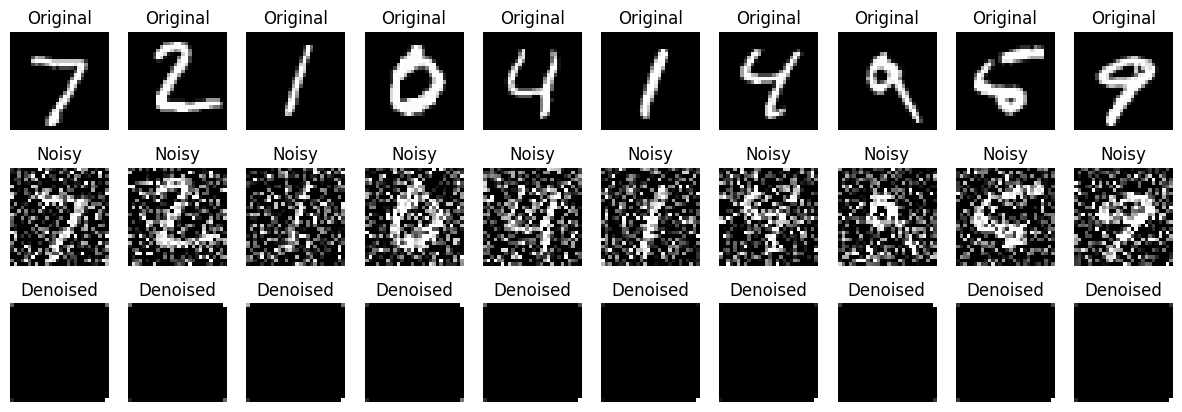

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Step 1: Load and preprocess data (use MNIST dataset)
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape to add a channel dimension
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Step 2: Add noise to simulate the diffusion process
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # Keep pixel values in range [0, 1]
    return noisy_images

noisy_train = add_noise(X_train)
noisy_test = add_noise(X_test)

# Step 3: Build a simple denoising model
def build_denoising_model():
    input_img = layers.Input(shape=(28, 28, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mse')

    return model

# Create and compile the model
denoising_model = build_denoising_model()
denoising_model.summary()

# Step 4: Train the model
history = denoising_model.fit(
    noisy_train, X_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test, X_test)
)

# Step 5: Denoise images and visualize the results
decoded_imgs = denoising_model.predict(noisy_test[:10])

# Plot original, noisy, and denoised images
n = 10
plt.figure(figsize=(15, 5))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(noisy_test[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

plt.show()
